In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import pandas as pd
# import projx as px fails in python3
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs
import seaborn as sns

In [3]:
plt.rcParams['figure.figsize'] = (12, 7)

In [4]:
def prob_dist(itrbl):
    count = {}
    for i in itrbl:
        count.setdefault(i, 0)
        count[i] += 1
    sr = pd.Series(count)
    prob = sr.apply(lambda x: float(x) / len(itrbl))
    return prob


def basic_graph_stats(g):
    stats = {
        "num_nodes": len(g),
        "num_edges": len(g.edges()),
        "density": nx.density(g),
        "diameter": nx.diameter(g),
        "avg_short_path": nx.average_shortest_path_length(g),
        "avg_clust": nx.average_clustering(g),
        "transitivity": nx.transitivity(g)
    }
    return pd.Series(stats) 

In [5]:
graph = nx.read_gexf("projections/fifty_percent_cut.gexf")

In [6]:
subgraphs = list(nx.connected_component_subgraphs(graph))
print([len(sub) for sub in subgraphs])

[236]


In [7]:
g = subgraphs[0]

In [8]:
nx.write_gexf(g, "projections/subgraph_fifty_cut.gexf")

In [9]:
basic_graph_stats(g)

avg_clust            0.803597
avg_short_path       2.809701
density              0.044464
diameter             6.000000
num_edges         1233.000000
num_nodes          236.000000
transitivity         0.329093
dtype: float64

### Centrality

In [10]:
bc = nx.betweenness_centrality(g, weight="weight")
ec = nx.eigenvector_centrality(g, weight="weight", max_iter=500)
cc = nx.closeness_centrality(g)
deg = nx.degree(g)
pr = nx.pagerank(g, max_iter=500, weight="weight")

In [11]:
cent_10_df = pd.DataFrame({
    "bc": [(k, g.node[k]["label"], bc[k]) for k in sorted(bc, key=bc.get, reverse=True)[0:10]],
    "ec": [(k, g.node[k]["label"], ec[k]) for k in sorted(ec, key=ec.get, reverse=True)[0:10]],
    "cc": [(k, g.node[k]["label"], cc[k]) for k in sorted(cc, key=cc.get, reverse=True)[0:10]],
    "dc": [(k, g.node[k]["label"], deg[k]) for k in sorted(deg, key=deg.get, reverse=True)[0:10]],
    "pr": [(k, g.node[k]["label"], pr[k]) for k in sorted(pr, key=pr.get, reverse=True)[0:10]]
})

In [12]:
print(cent_10_df)

                                                  bc  \
0  (440, Felix Lope de Vega Carpio, 0.19710671632...   
1  (184, Pedro Fernandez de Castro, Conde de Lemo...   
2           (437, Alonso Perez, 0.14143666813879577)   
3  (153, Sebastian de Cormellas, 0.12824536780375...   
4            (70, Mateo Aleman, 0.10228798317192372)   
5          (3, Bernardo Grassa, 0.09986451728950368)   
6  (208, Miguel de Cervantes Saavedra, 0.09597349...   
7        (207, Jorge Rodriguez, 0.08096021031616978)   
8        (267, Juan de Bonilla, 0.05804691762138571)   
9  (215, Francisco Murcia de la Llana, 0.05423760...   

                                                  cc  \
0  (440, Felix Lope de Vega Carpio, 0.54524361948...   
1  (215, Francisco Murcia de la Llana, 0.51762114...   
2  (100, Gutierre de Cetina, Vicario General, 0.4...   
3  (208, Miguel de Cervantes Saavedra, 0.47667342...   
4      (209, Ruy Pirez da Veiga, 0.4737903225806452)   
5  (153, Sebastian de Cormellas, 0.470941883767

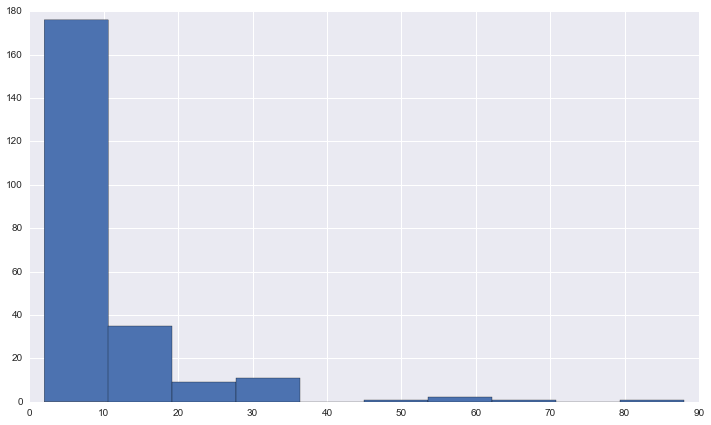

In [13]:
pd.Series(list(deg.values())).hist()

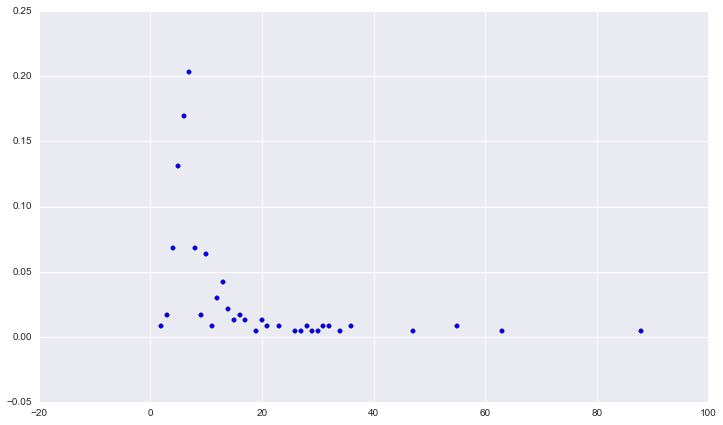

In [14]:
deg_prob = prob_dist(list(deg.values()))
plt.scatter(deg_prob.index, deg_prob)

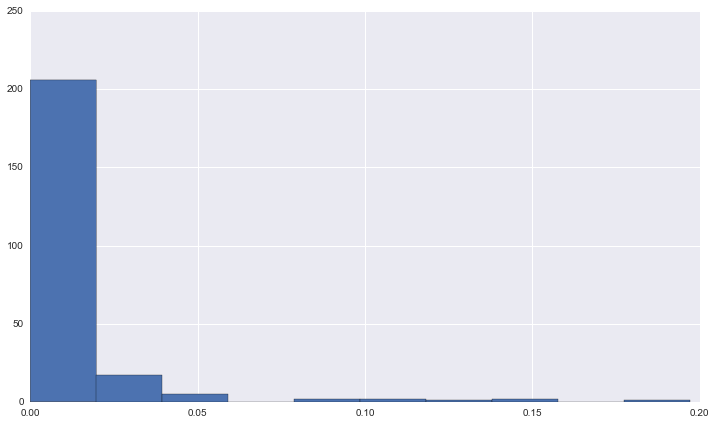

In [15]:
pd.Series(list(bc.values())).hist()

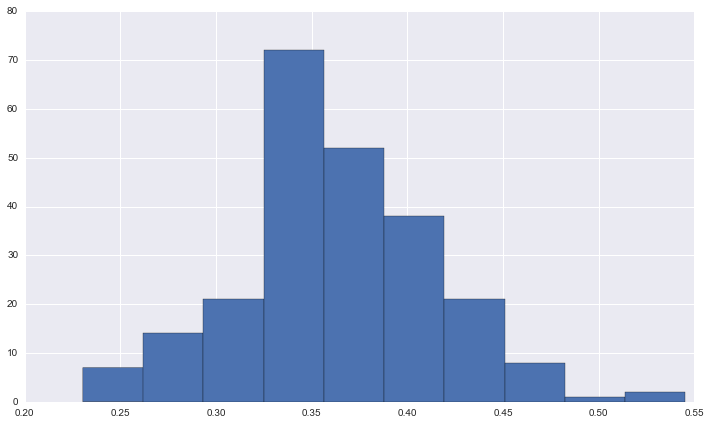

In [16]:
pd.Series(list(cc.values())).hist()

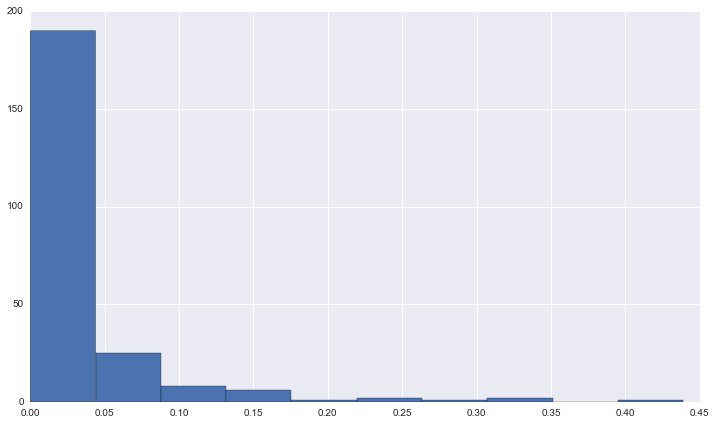

In [17]:
pd.Series(list(ec.values())).hist()

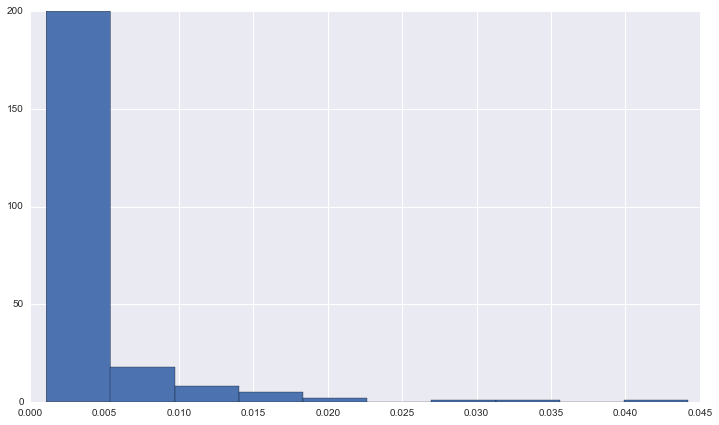

In [18]:
pd.Series(list(pr.values())).hist()

### Assortativity

#### Degree

In [19]:
nx.degree_assortativity_coefficient(g)

-0.13397654720435853

In [20]:
r = nx.degree_assortativity_coefficient(g)
print("%3.1f"%r)

-0.1


In [21]:
nodes_by_deg = sorted(deg, key=deg.get, reverse=True)
mtrx = nx.to_numpy_matrix(g, nodelist=nodes_by_deg)

In [22]:
weight_sr = pd.Series([attrs["weight"] for s, t, attrs in g.edges(data=True)])
weight_sr.describe()

count    1233.000000
mean        0.281060
std         0.233581
min         0.142857
25%         0.166667
50%         0.200000
75%         0.309524
max         2.602381
dtype: float64

In [23]:
quant = weight_sr.quantile(.75)

In [24]:
plt.rcParams['figure.figsize'] = (12, 7)
mtrx

matrix([[ 0.        ,  1.67604428,  0.        , ...,  0.33333333,
          0.        ,  0.        ],
        [ 1.67604428,  0.        ,  0.77738095, ...,  0.        ,
          0.        ,  0.19444444],
        [ 0.        ,  0.77738095,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.33333333,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.19444444,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [25]:
#colors = [('purple')] + [(cm.jet(i)) for i in xrange(1,256)]
#new_map = clrs.LinearSegmentedColormap.from_list('new_map', colors, N=256)
# heatmap = plt.imshow(mtrx, interpolation='nearest')
# heatmap.set_clim(0.0, quant)
# plt.colorbar()
# sns.heatmap(mtrx)
# plt.savefig("img/cutlines_deg_assort.png")


In [26]:
stripmtrx = mtrx[:100, :50]

In [27]:
# heatmap = plt.imshow(stripmtrx)
# heatmap.set_clim(0.0, quant)
# plt.colorbar()
# sns.heatmap(stripmtrx)

In [28]:
zoommtrx = nx.to_numpy_matrix(g, nodelist=nodes_by_deg)[:50, :50]

In [29]:
zoomquant = pd.Series(zoommtrx.flatten().tolist()[0]).quantile(0.9)

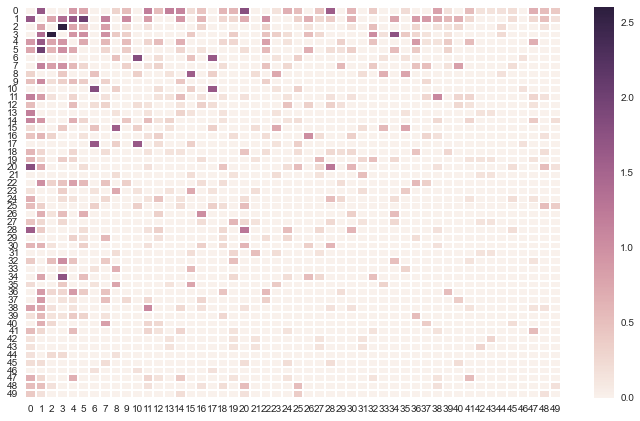

In [30]:
# heatmap = plt.imshow(zoommtrx)
# heatmap.set_clim(0.0, zoomquant)
# plt.colorbar()
sns.heatmap(zoommtrx)

#### Attribute

In [31]:
place = nx.attribute_assortativity_coefficient(g, "top_place")

In [32]:
genre = nx.attribute_assortativity_coefficient(g, "top_genre")

In [33]:
role = nx.attribute_assortativity_coefficient(g, "role")

In [34]:
assort_df = pd.Series({
    "deg": r,
    "role": role,
    "place": place,
    "genre": genre
})
assort_df

deg     -0.133977
genre    0.455555
place    0.251043
role    -0.121747
dtype: float64

Remove author/patron

In [35]:
no_auth_patron = g.copy()
# g.nodes(data=True)

In [46]:
no_auth_patron = g.copy()
for node, attrs in g.nodes(data=True):
    if attrs.get("role", "") == "author" or attrs.get("role", "") == "patron" or not attrs.get("top_place"):
        no_auth_patron.remove_node(node)

In [48]:
len(no_auth_patron.nodes())
place = nx.attribute_assortativity_coefficient(no_auth_patron, "top_place")
place

0.6271698019463784

In [49]:
comps = list(nx.connected_component_subgraphs(no_auth_patron))
for x in comps:
    print(len(x.nodes()))

4
105
5
22
9
1
5
4
2
1


In [51]:
def group_by_top_place(g):
    places = {}
    current = 1
    for n, attrs in g.nodes(data=True):
        tp = attrs["top_place"]
        if tp not in places:
            places[tp] = int(current)
            group = int(current)
            current += 1
        else:
            group = places[tp]
        g.node[n]["group"] = group
    return g

In [53]:
no_auth_patron = group_by_top_place(no_auth_patron)
no_auth_patron.nodes(data=True)

[('93',
  {'avg_date': '1605',
   'doc_type': "{u'Impresion': 1}",
   'fecha': "{'1605-01-01': 1}",
   'genero': "{'Teatro': 1}",
   'group': 1,
   'label': 'Gaspar Leget',
   'lugar': "{u'Valencia': 1}",
   'real': "{'True': 1}",
   'role': 'printer/editor',
   'second_genre': '',
   'second_place': '',
   'top_genre': 'Teatro',
   'top_place': 'Valencia',
   'type': 'Persona'}),
 ('246',
  {'avg_date': '1598',
   'doc_type': "{u'Aprobacion': 2}",
   'fecha': "{'1598-08-06': 1, '1599-01-22': 1}",
   'genero': "{'Ficcion': 6, 'Poesia': 3}",
   'group': 2,
   'inst': "{u'Convento de nuestra senora del Carmen': 1, u'Orden de los carmelitas': 1}",
   'label': 'Pedro de Padilla, Fray',
   'lugar': "{u'Madrid': 2}",
   'real': "{'True': 1}",
   'role': 'signatory',
   'second_genre': 'Poesia',
   'second_place': '',
   'top_genre': 'Ficcion',
   'top_place': 'Madrid',
   'type': 'Persona'}),
 ('107',
  {'avg_date': '',
   'doc_type': "{u'Privilegio/Licencia': 1}",
   'fecha': "{'': 1}",
   

In [54]:
nx.write_gexf(no_auth_patron, "projections/no_auth_patron.gexf")

Betweenness

In [41]:
b = nx.betweenness_centrality(g)

In [42]:
d = {"author": [], "signatory": [], "patron": [], "printer/editor": []}
for k, v in b.items():
    role = g.node[k].get("role", "")
    if role:
        d[role].append(v)

(0.0, 0.08)

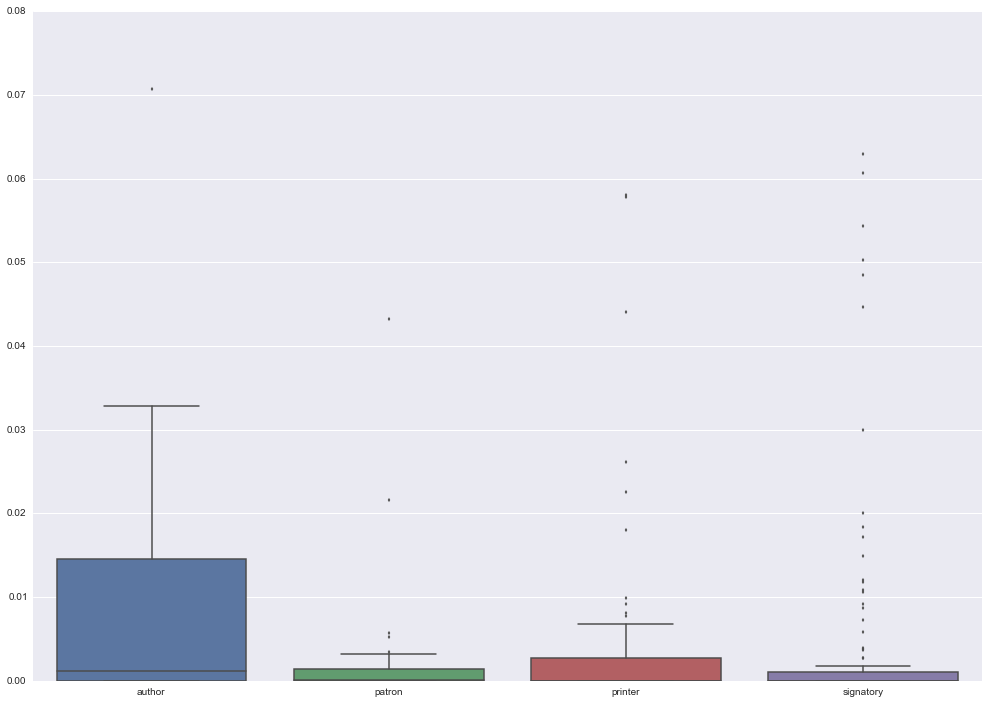

In [43]:
import numpy as np
sns.boxplot([d["author"],  d["patron"], d["printer/editor"], d["signatory"]], names=["author", "patron", "printer", "signatory"])
plt.ylim(0.0, 0.08)

(array([ 17.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.        ,  0.03039818,  0.06079637,  0.09119455,  0.12159274,
         0.15199092,  0.18238911,  0.21278729,  0.24318548,  0.27358366,
         0.30398184]),
 <a list of 10 Patch objects>)

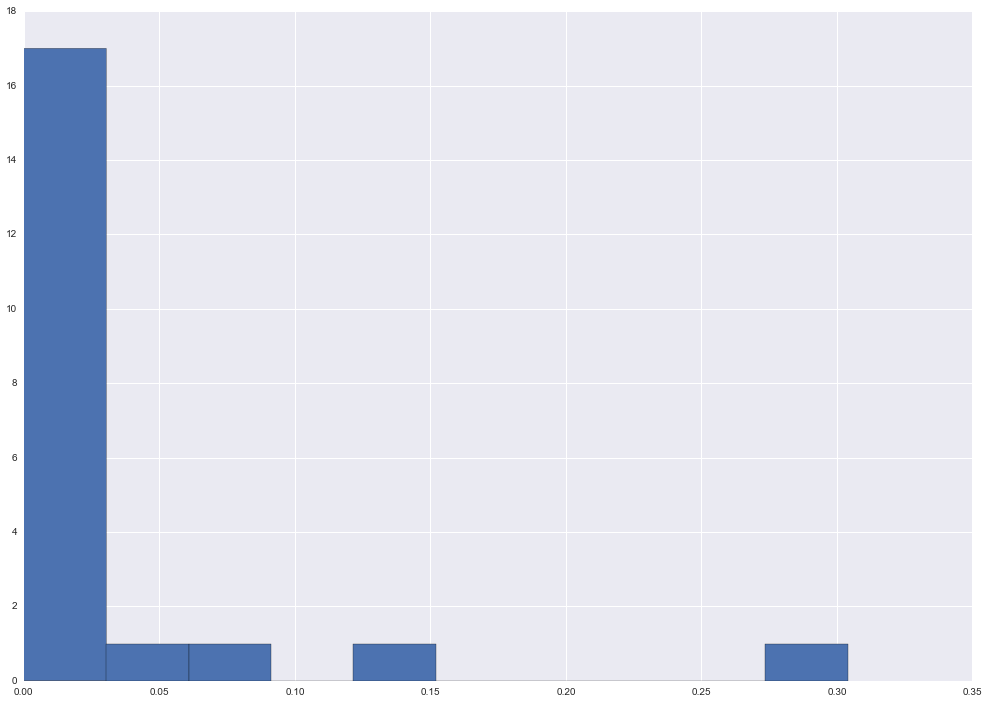

In [44]:
plt.hist(d["author"])

### Clustering

In [45]:
nx.average_clustering(g)

0.8035973273010207

TypeError: unorderable types: dict_values() <= dict_values()

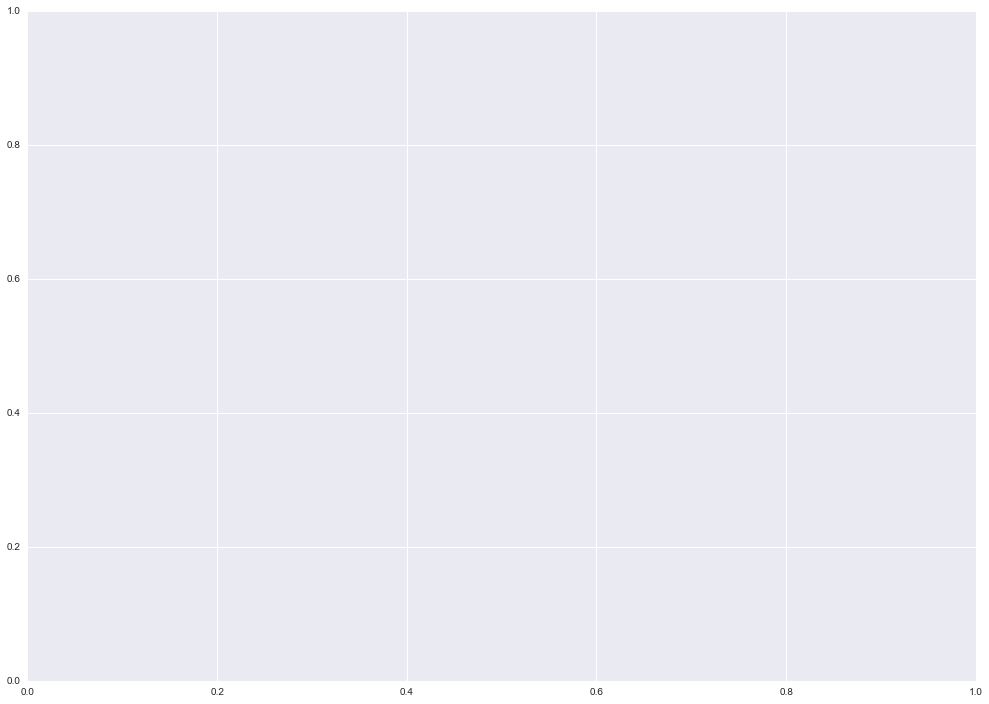

In [46]:
pd.Series(nx.clustering(g).values()).hist()

In [47]:
nx.transitivity(g)

0.3290931989924433

### Paths

In [48]:
nx.diameter(g)

6

In [49]:
nx.average_shortest_path_length(g)

2.809700685178507

###Modularity

In [68]:
mod_df = pd.read_csv("data/modularity.csv", encoding="utf-8")
mod_map = {3: 1, 2: 2, 5: 3, 9: 4, 4: 5, 8: 6, 0: 7, 1: 8, 7: 9, 6: 10}
mod_df["Modularity Class"] = mod_df["Modularity Class"].apply(lambda x: mod_map[x])

In [69]:
mod = mod_df.groupby("Modularity Class").size()

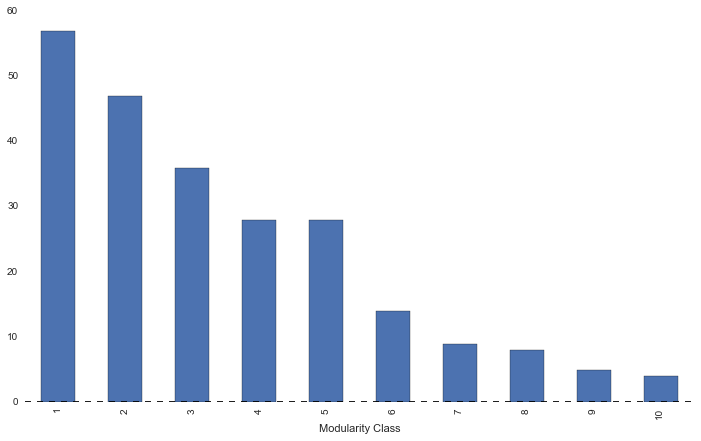

In [70]:
mod.plot(kind="bar")

In [71]:
mod_places = mod_df.groupby(["Modularity Class", "top_place"]).size()

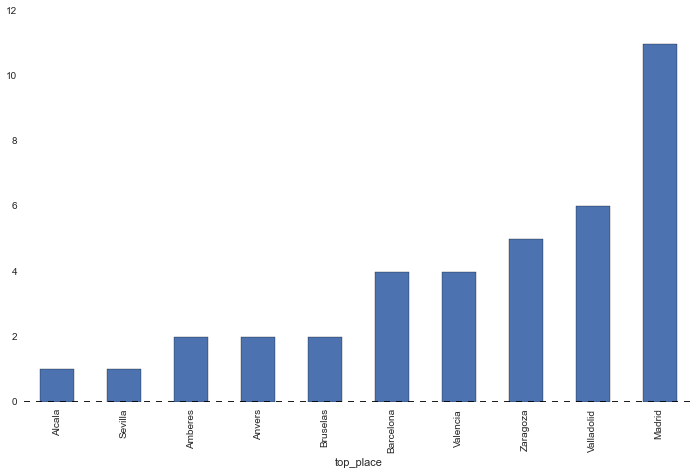

In [72]:
one = mod_places[1]
one.sort()
one.plot(kind="bar")
# Core group Castile -> Aragon

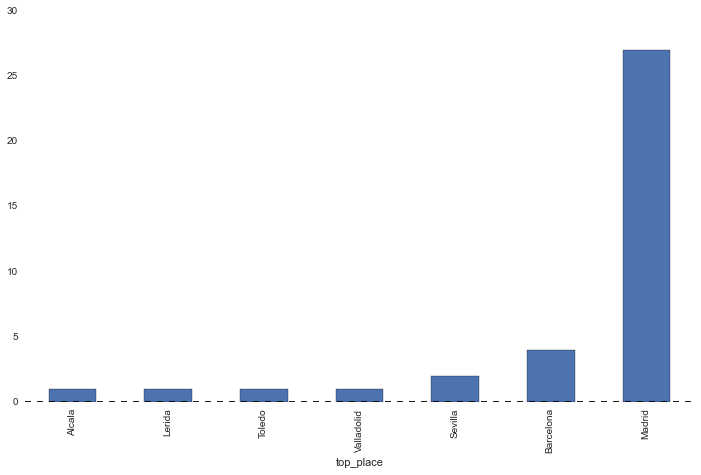

In [73]:
two = mod_places[2]
two.sort()
two.plot(kind="bar")
# Core madrid

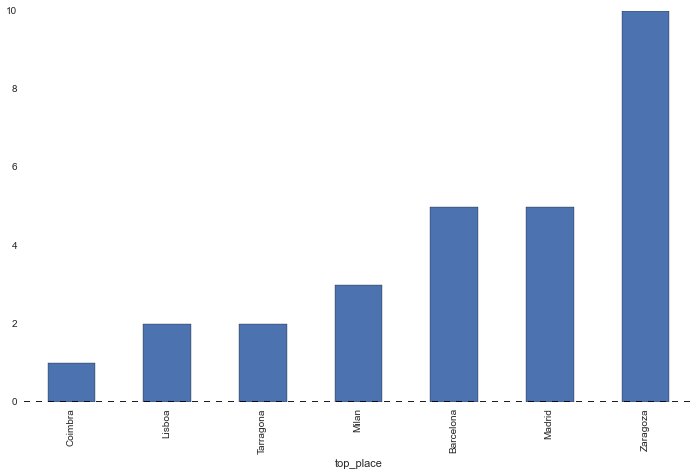

In [74]:
three = mod_places[3]
three.sort()
three.plot(kind="bar")
# Core Zaragoza in between Madrid and Barcelona

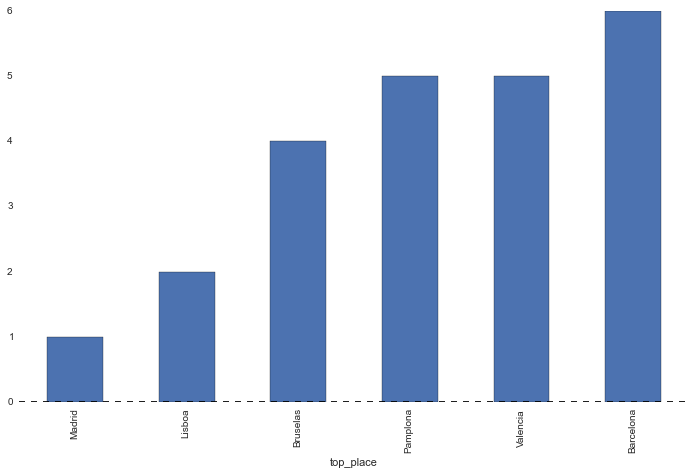

In [75]:
four = mod_places[4]
four.sort()
four.plot(kind="bar")
# Aragon

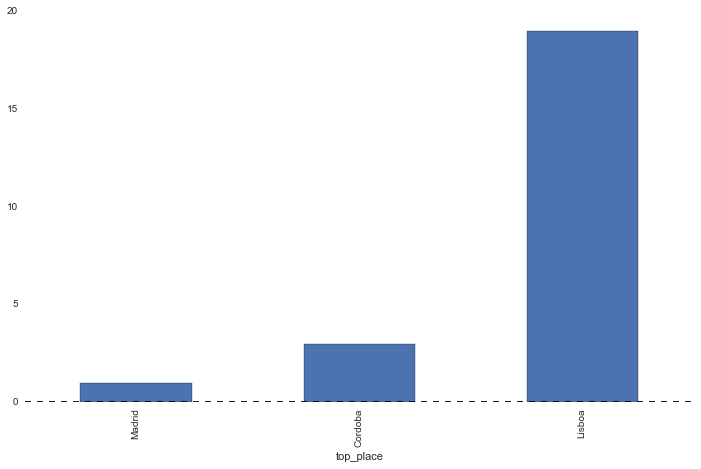

In [76]:
five = mod_places[5]
five.sort()
five.plot(kind="bar")
# Lisbon

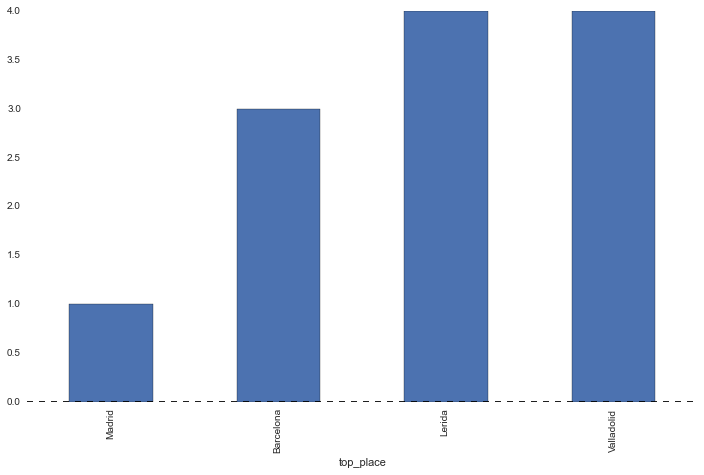

In [77]:
six = mod_places[6]
six.sort()
six.plot(kind="bar")

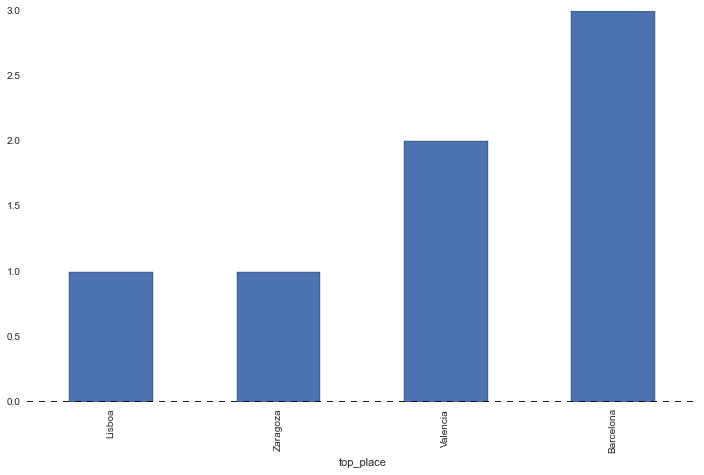

In [78]:
seven = mod_places[7]
seven.sort()
seven.plot(kind="bar")

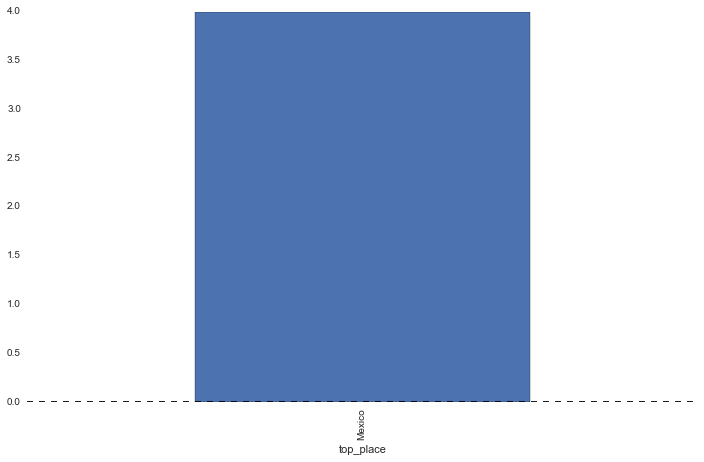

In [79]:
eight = mod_places[8]
eight.sort()
eight.plot(kind="bar")

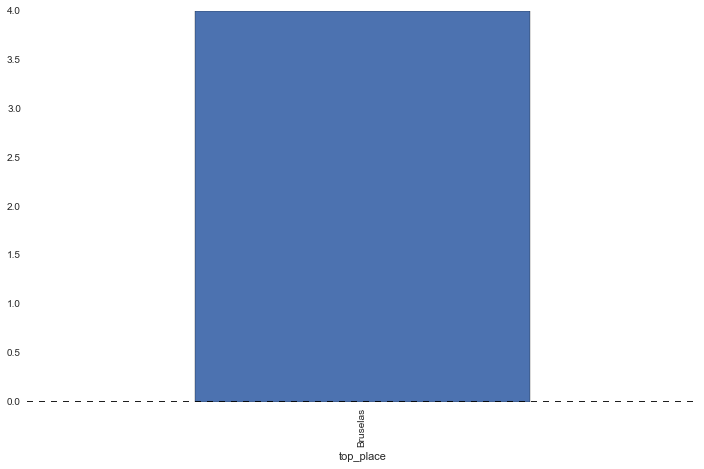

In [80]:
nine = mod_places[9]
nine.sort()
nine.plot(kind="bar")

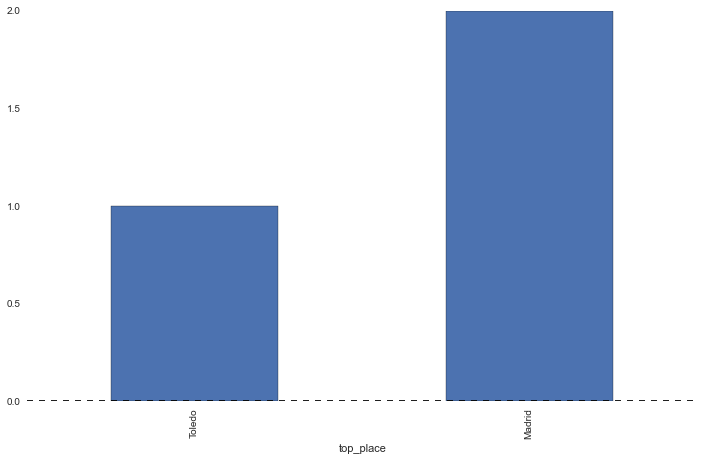

In [81]:
ten = mod_places[10]
ten.sort()
ten.plot(kind="bar")

In [82]:
mod_places = mod_df.groupby(["role", "Modularity Class"]).size()
mod_places

role            Modularity Class
author          1                    2
                2                    7
                3                    2
                4                    1
                5                    2
                6                    3
                7                    1
                8                    1
                9                    1
                10                   1
patron          1                    9
                2                    5
                3                    4
                4                    2
                5                    4
                6                    1
                7                    1
                8                    2
                9                    1
                10                   1
printer/editor  1                   16
                2                    9
                3                   14
                4                    8
                5              

In [83]:
df = pd.DataFrame({
        "author": mod_places["author"],
        "patron": mod_places["patron"],
        "printer/editor": mod_places["printer/editor"],
        "signatory": mod_places["signatory"]})

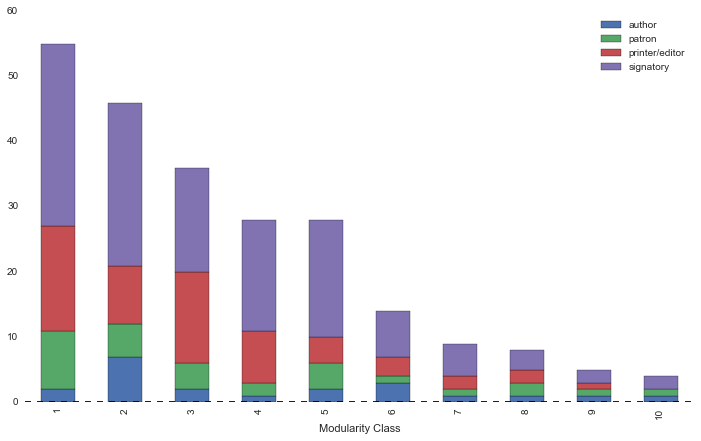

In [84]:
df.plot(kind="bar", stacked=True)

In [85]:
mod_df.groupby([

,Id,Label,real,lugar,top_place,notas,doc_type,fecha,genero,top_genre,second_place,inst,second_genre,role,avg_date,type,author,Modularity Class
0,73,Galvan,{'True': 1},{u'Zaragoza': 1},Zaragoza,{'Asesor': 1},{u'Privilegio/Licencia': 1},{'1599-06-22': 1},{'Ficcion': 1},Ficcion,NaN,NaN,NaN,signatory,1599,Persona,NaN,3
1,106,"Pedro de Molina, Vicario General de Zaragoza",{'True': 1},{u'Zaragoza': 1},Zaragoza,NaN,{u'Privilegio/Licencia': 1},{'1617-08-15': 1},{'Historia': 1},Historia,NaN,{u'Archidiocesis de Zaragoza': 1},NaN,signatory,1617,Persona,NaN,3
2,104,"Diego Carrillo de Mendoza y Pimentel, Virrey d...",{'True': 1},{u'Zaragoza': 1},Zaragoza,{'Marques de Gelbes': 1},{u'Privilegio/Licencia': 1},{'1617-04-18': 1},{'Historia': 1},Historia,NaN,"{u'Marquesado de Gelves': 1, u'Condado de Prie...",NaN,signatory,1617,Persona,NaN,3
3,105,Agustin de Morlanes,{'True': 1},{u'Zaragoza': 1},Zaragoza,NaN,{u'Aprobacion': 1},{'1617-04-16': 1},{'Historia': 1},Historia,NaN,NaN,NaN,signatory,1617,Persona,NaN,3
4,143,Pedro Morejon,{'True': 1},{u'Zaragoza': 1},Zaragoza,NaN,{u'Obra': 1},{'1617-04-18': 1},{'Historia': 1},Historia,NaN,{u'Compania de Jesus': 1},NaN,author,1617,Persona,{'true': 1},3


In [135]:
mod_places = mod_df.groupby(["Modularity Class", "role"]).size()

In [136]:
mod_places = mod_places.reset_index()

In [137]:
mod_places = mod_df.groupby(["Modularity Class", "role"]).size()

In [138]:
grouped = mod_places.groupby(level=0)

In [139]:
grouped.sum()

Modularity Class
1                   55
2                   46
3                   36
4                   28
5                   28
6                   14
7                    9
8                    8
9                    5
10                   4
dtype: int64

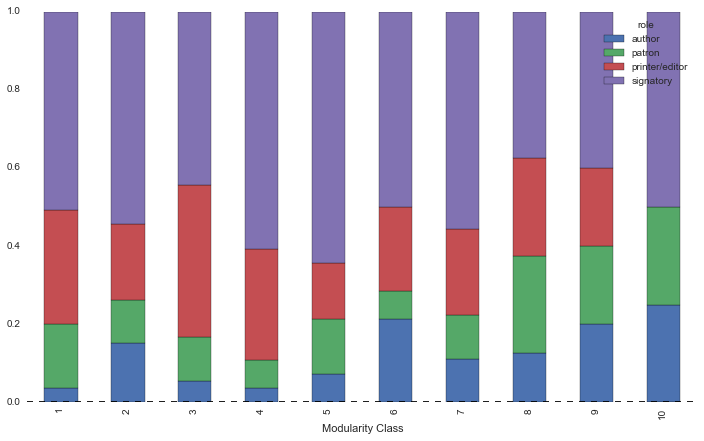

In [163]:
divided = mod_places.divide(grouped.sum())
# divided = divided.reset_index()
divided = divided.unstack(level=0).fillna(0)
trans = divided.transpose()
trans.plot(kind="bar", stacked=True)
# trans

In [166]:
trans

role,author,patron,printer/editor,signatory
Modularity Class,,,,
1,0.036364,0.163636,0.290909,0.509091
2,0.152174,0.108696,0.195652,0.543478
3,0.055556,0.111111,0.388889,0.444444
4,0.035714,0.071429,0.285714,0.607143
5,0.071429,0.142857,0.142857,0.642857
6,0.214286,0.071429,0.214286,0.500000
7,0.111111,0.111111,0.222222,0.555556
8,0.125000,0.250000,0.250000,0.375000
9,0.200000,0.200000,0.200000,0.400000


In [132]:
regroup = divided.groupby(["role", "Modularity Class", ]).

In [133]:
mod_places.groups

{('author', 1): [0],
 ('author', 2): [4],
 ('author', 3): [8],
 ('author', 4): [12],
 ('author', 5): [16],
 ('author', 6): [20],
 ('author', 7): [24],
 ('author', 8): [28],
 ('author', 9): [32],
 ('author', 10): [36],
 ('patron', 1): [1],
 ('patron', 2): [5],
 ('patron', 3): [9],
 ('patron', 4): [13],
 ('patron', 5): [17],
 ('patron', 6): [21],
 ('patron', 7): [25],
 ('patron', 8): [29],
 ('patron', 9): [33],
 ('patron', 10): [37],
 ('printer/editor', 1): [2],
 ('printer/editor', 2): [6],
 ('printer/editor', 3): [10],
 ('printer/editor', 4): [14],
 ('printer/editor', 5): [18],
 ('printer/editor', 6): [22],
 ('printer/editor', 7): [26],
 ('printer/editor', 8): [30],
 ('printer/editor', 9): [34],
 ('signatory', 1): [3],
 ('signatory', 2): [7],
 ('signatory', 3): [11],
 ('signatory', 4): [15],
 ('signatory', 5): [19],
 ('signatory', 6): [23],
 ('signatory', 7): [27],
 ('signatory', 8): [31],
 ('signatory', 9): [35],
 ('signatory', 10): [38]}